Author: Cezary Januszek

*Created on Saturday, November 15th 2023*
# [Swisscom challenge] Flight delays prediction

#### Research question: *What is the influence of the different airlines/airports on the flight delays?*

The goal of this challenge is to investigate US flight delays and cancellations data from 2015.

First some exploratory data analysis is done to try to find some insights from general statistics about the airlines, airports and average flight delays. Second, using this same data the goal consists in creating a flight delay prediction model by implementing a:
1) baseline model
2) complex model (Neural Network or other Deep Learning method)

The second model should have better performance than the baseline due to its increased complexity, which will make it also more difficult to explain its predictions.Therefore, an interpretability framework will be added to the second model to allow explicability of the created predictions.

# IV. Complex prediction model

In [6]:
# Imports
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from IPython.core.pylabtools import figsize
figsize(8, 6)

from helper_functions import *

from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torcheval.metrics.functional import multiclass_confusion_matrix, multiclass_accuracy, multiclass_precision, multiclass_recall, multiclass_auprc, multiclass_f1_score

#import torch_explain as te
#from torch_explain.logic.nn import entropy

from captum.attr import IntegratedGradients

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using cpu device


In [7]:
# load the data
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_pickle('drive/MyDrive/FlightDelayPrediction/flights_data.pkl')

Mounted at /content/drive


### Last pre-processing step for Neural Network

In [8]:

# cyclical encoding of time and date
data = cyclical_encode(data, 'DAY_OF_WEEK', 7)
data = cyclical_encode(data, 'DEPARTURE_DAY', 31)
data = cyclical_encode(data, 'DEPARTURE_MONTH', 12)
data = cyclical_encode(data, 'ARRIVAL_DAY', 31)
data = cyclical_encode(data, 'ARRIVAL_MONTH', 12)

data = cyclical_encode(data, 'SCHEDULED_DEPARTURE_HOUR', 24)
data = cyclical_encode(data, 'SCHEDULED_DEPARTURE_MIN', 60)
data = cyclical_encode(data, 'SCHEDULED_ARRIVAL_HOUR', 24)
data = cyclical_encode(data, 'SCHEDULED_ARRIVAL_MIN', 60)

data = data.drop(['DAY_OF_WEEK', 'DEPARTURE_DAY', 'DEPARTURE_MONTH', 'ARRIVAL_DAY', 'ARRIVAL_MONTH',
                             'SCHEDULED_DEPARTURE_HOUR', 'SCHEDULED_DEPARTURE_MIN', 'SCHEDULED_ARRIVAL_HOUR', 'SCHEDULED_ARRIVAL_MIN'], axis=1)


## Multi-layer Perceptron for multi-class classification

In [9]:
#-----------------------------
# Multi-layer Perceptron model
#------------------------------

class MLP(nn.Module):

    def __init__(self, input_size, layer1_size, layer2_size, layer3_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, layer1_size),
            nn.PReLU(),
            nn.Linear(layer1_size, layer2_size),
            nn.PReLU(),
            nn.Linear(layer2_size, layer3_size),
            nn.PReLU(),
            nn.Linear(layer3_size, output_size)
        )
        self.model.to(device)

    def forward(self, x):
        fwd_output = self.model(x)
        return fwd_output

    def save_model(self, filepath):
        torch.save(self.state_dict(), filepath)

    def load_model(self, filepath):
        self.load_state_dict(torch.load(filepath))


'''
JUST AN IDEA -> NOT USED :(

# Define the Attention Layer
class AttentionLayer(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(AttentionLayer, self).__init__()
        self.W_q = nn.Linear(input_size, hidden_size)
        self.W_k = nn.Linear(input_size, hidden_size)
        self.W_v = nn.Linear(input_size, hidden_size)
        self.W_out = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        x = x.unsqueeze(1)

        query = self.W_q(x)
        key = self.W_k(x)
        value = self.W_v(x)

        # Compute attention weights
        attention_weights = torch.softmax(torch.matmul(query, key.transpose(1,2)), dim=-1)
        # Apply attention weights to values
        attention_values = torch.matmul(attention_weights, value)
        # Combine attended values using a linear layer
        attention_output = self.W_out(attention_values.squeeze(1))

        return attention_output, attention_weights

class AttentionMLP(nn.Module):

    def __init__(self, input_size, layer1_size, layer2_size, layer3_size, attention_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, layer1_size),
            nn.PReLU(),
            nn.Linear(layer1_size, layer2_size),
            nn.PReLU(),
            nn.Linear(layer2_size, layer3_size),
            nn.PReLU(),
            AttentionLayer(layer3_size, attention_size)
        )
        self.output_layer = nn.Linear(attention_size, output_size)

        self.layers.to(device)
        self.output_layer.to(device)

    def forward(self, x):
        x, attention_weights = self.layers(x)
        x = torch.relu(x)
        fwd_output = self.output_layer(x)

        return fwd_output, attention_weights
'''
#------------------------------------
# Train and validation loop functions
#------------------------------------

def train_loop(model, train_loader, optim, criterion):
  '''
  Training loop function
  '''
  # Mini-batch loop
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # Zero the gradients for each new mini-batch loop
    optim.zero_grad()
    # Forward pass
    outputs = model(inputs)
    # Compute the loss
    loss = criterion(outputs, labels)
    # Backward pass and optimization
    loss.backward()
    optim.step()

  return loss.item()


def test_loop(model, test_loader, optim, criterion):
  '''
  Validation loop function
  '''
  # No grad computation is needed
  with torch.no_grad():

    for inputs_test, labels_test in test_loader:
      inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
      # Forward pass
      outputs_test = model(inputs_test)
      # Compute the loss
      loss_test = criterion(outputs_test, labels_test)

  return loss_test.item()


def average_test_loss_accuracy(model, test_loader, criterion):
  '''
  Get the average loss and global accuracy on test set
  '''
  with torch.no_grad():
      total_loss_test = 0.0
      correct_predictions_test = 0
      total_samples_test = 0

      for inputs_test, labels_test in test_loader:
          inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)

          outputs_test = model(inputs_test)
          loss_test = criterion(outputs_test, labels_test)
          total_loss_test += loss_test.item()

          _, predicted_test = torch.max(outputs_test, 1)
          correct_predictions_test += (predicted_test == labels_test).sum().item()
          total_samples_test += labels_test.size(0)

      average_loss_test = total_loss_test / len(test_loader)
      accuracy_test = correct_predictions_test / total_samples_test

      print(f'Average test loss: {average_loss_test:.4f}, Accuracy: {accuracy_test * 100:.2f}%')

## Without DEPARTURE_DELAY feature

In [10]:
# separate data into feature matrix X and target variable vector Y
X = pd.get_dummies(data.drop(['DEPARTURE_DELAY', 'ARRIVAL_DELAY'], axis=1))
Y = data['ARRIVAL_DELAY']

In [11]:
# train-test split with test size of 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
print('Train samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])
print(Counter(Y_train))

# Standardize data
scaler = StandardScaler().fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Training data to tensors
X_train = torch.as_tensor(X_train, dtype=torch.float32, device=device)
Y_train = torch.as_tensor(np.array(Y_train), device=device)
X_test = torch.as_tensor(X_test, dtype=torch.float32, device=device)
Y_test = torch.as_tensor(np.array(Y_test), device=device)

Train samples:  976964
Test samples:  418700
Counter({0: 788206, 1: 128950, 2: 50797, 3: 9011})


In [12]:
# Instantiate the model
mlp_model = MLP(X.shape[1], 100, 100, 100, 4)
# Loss function
loss_criterion = nn.CrossEntropyLoss()
# Adam optimizer
# learning rates tested [1-e3, 1e-4, 1e-5]
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-5)

# Define number of epochs and mini-batch size
num_epochs = 50
# batch sizes tested [500, 1000, 2000]
batch_size = 5000

# DataLoader for creating training and validation batches
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#----------
# Training
#----------

train_loss_array = []
test_loss_array = []

# Epoch loop
for e in range(num_epochs):
  # Training step
  train_loss = train_loop(mlp_model, train_loader, optimizer, loss_criterion)
  # Save epoch loss for plot
  train_loss_array.append(train_loss)
  # Validation step
  test_loss = test_loop(mlp_model, test_loader, optimizer, loss_criterion)
  # Save epoch loss for plot
  test_loss_array.append(test_loss)

  print(f'Epoch [{e+1}/{num_epochs}], Training loss: {train_loss:.4f}, Test loss: {test_loss: 4f}')


Epoch [1/50], Training loss: 1.3429, Test loss:  1.341417
Epoch [2/50], Training loss: 1.2388, Test loss:  1.230217
Epoch [3/50], Training loss: 1.0881, Test loss:  1.092273
Epoch [4/50], Training loss: 0.9296, Test loss:  0.917340
Epoch [5/50], Training loss: 0.7811, Test loss:  0.785478
Epoch [6/50], Training loss: 0.6997, Test loss:  0.703697
Epoch [7/50], Training loss: 0.7025, Test loss:  0.689747
Epoch [8/50], Training loss: 0.6892, Test loss:  0.662954
Epoch [9/50], Training loss: 0.6409, Test loss:  0.621749
Epoch [10/50], Training loss: 0.6610, Test loss:  0.637245
Epoch [11/50], Training loss: 0.6399, Test loss:  0.633058
Epoch [12/50], Training loss: 0.6188, Test loss:  0.621230
Epoch [13/50], Training loss: 0.6192, Test loss:  0.636465
Epoch [14/50], Training loss: 0.6236, Test loss:  0.602099
Epoch [15/50], Training loss: 0.6004, Test loss:  0.610951
Epoch [16/50], Training loss: 0.6510, Test loss:  0.635604
Epoch [17/50], Training loss: 0.5973, Test loss:  0.620130
Epoch 

In [15]:
# save model
mlp_model.save_model(os.path.abspath('./model/mlp_without_DepartureDelay.pt'))

In [16]:
average_test_loss_accuracy(mlp_model, test_loader, loss_criterion)

Average test loss: 0.6114, Accuracy: 80.68%


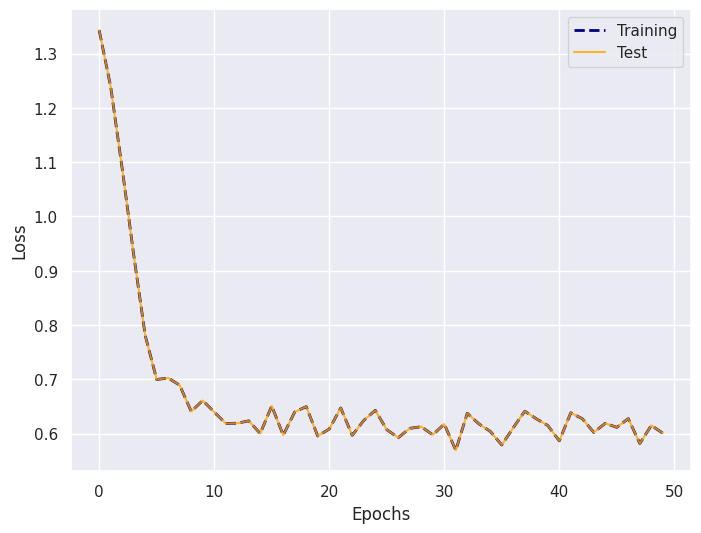

In [17]:
plt.figure()
plt.plot(range(num_epochs), train_loss_array, label='Training', linestyle='dashed', linewidth=2, color='navy')
plt.plot(range(num_epochs), train_loss_array, label='Test', alpha=0.8, color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Accuracy = 0.250
Precision = 0.202
Recall = 0.250
F1-score = 0.223
Area under PRC = 0.285


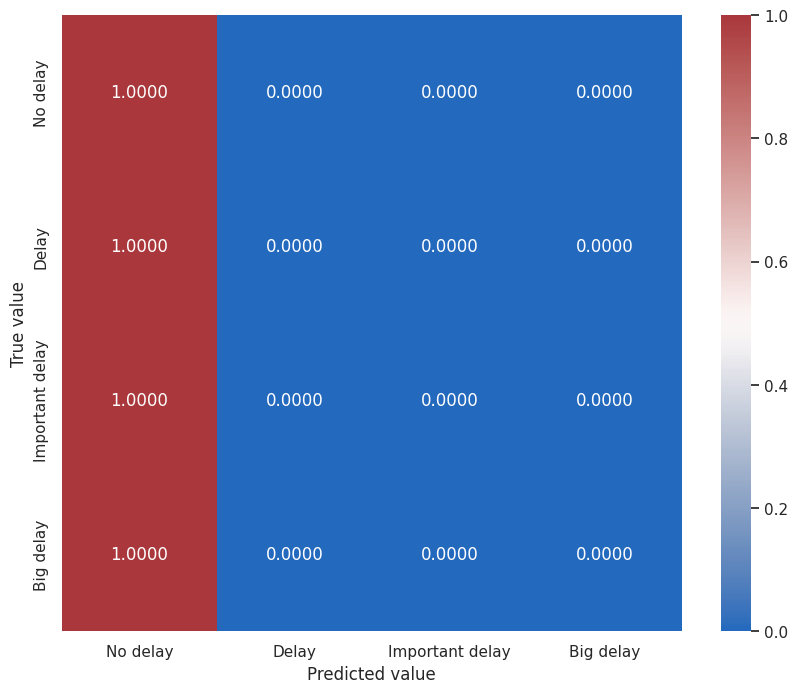

In [19]:
# Evaluate performance with various metrics
Y_pred = mlp_model(X_test)

print('Accuracy = {:.3f}'.format(multiclass_accuracy(Y_pred, Y_test, average='macro', num_classes=4)))
print('Precision = {:.3f}'.format(multiclass_precision(Y_pred, Y_test, average='macro', num_classes=4)))
print('Recall = {:.3f}'.format(multiclass_recall(Y_pred, Y_test, average='macro', num_classes=4)))
print('F1-score = {:.3f}'.format(multiclass_f1_score(Y_pred, Y_test, average='macro', num_classes=4)))
print('Area under PRC = {:.3f}'.format(multiclass_auprc(Y_pred, Y_test, average='macro', num_classes=4)))

conf_matrix = multiclass_confusion_matrix(Y_pred, Y_test, num_classes=4, normalize='true').cpu().numpy()
conf_matrix = pd.DataFrame(conf_matrix, index=['No delay', 'Delay', 'Important delay', 'Big delay'], columns=['No delay', 'Delay', 'Important delay', 'Big delay'])

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, cmap='vlag', fmt='.4f')
plt.ylabel('True value')
plt.xlabel('Predicted value')
plt.show()

## With DEPARTURE_DELAY feature

In [5]:
# separate data into feature matrix X and target variable vector Y
X = pd.get_dummies(data.drop(['ARRIVAL_DELAY'], axis=1))
Y = data['ARRIVAL_DELAY']

In [6]:
# train-test split with test size of 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
print('Train samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])
print(Counter(Y_train))

# random under-sampling
#undersample = RandomUnderSampler(sampling_strategy={0: 400000})
#X_train, Y_train = undersample.fit_resample(X_train, Y_train)
#print('After balancing the classes: ', Counter(Y_train))

# Standardize data
scaler = StandardScaler().fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Training and test data to tensors
X_train = torch.as_tensor(X_train, dtype=torch.float32, device=device)
Y_train = torch.as_tensor(np.array(Y_train), device=device)
X_test = torch.as_tensor(X_test, dtype=torch.float32, device=device)
Y_test = torch.as_tensor(np.array(Y_test), device=device)

Train samples:  976964
Test samples:  418700
Counter({0: 788206, 1: 128950, 2: 50797, 3: 9011})


In [7]:
# Instantiate the model
mlp_model = MLP(X.shape[1], 100, 100, 100, 4)
# Loss function
loss_criterion = nn.CrossEntropyLoss()
# Adam optimizer
# learning rates tested [1-e3, 1e-4, 1e-5]
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-5)

# Define number of epochs and mini-batch size
num_epochs = 70
# batch sizes tested [500, 1000, 2000, 5000]
batch_size = 5000

# DataLoader for creating training and validation batches
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#----------
# Training
#----------

train_loss_array = []
test_loss_array = []

# Epoch loop
for e in range(num_epochs):
  # Training step
  train_loss = train_loop(mlp_model, train_loader, optimizer, loss_criterion)
  # Save epoch loss for plot
  train_loss_array.append(train_loss)
  # Validation step
  test_loss = test_loop(mlp_model, test_loader, optimizer, loss_criterion)
  # Save epoch loss for plot
  test_loss_array.append(test_loss)

  print(f'Epoch [{e+1}/{num_epochs}], Training loss: {train_loss:.4f}, Test loss: {test_loss: 4f}')

Epoch [1/70], Training loss: 1.2856, Test loss:  1.284611
Epoch [2/70], Training loss: 1.1640, Test loss:  1.164699
Epoch [3/70], Training loss: 1.0070, Test loss:  0.991937
Epoch [4/70], Training loss: 0.8532, Test loss:  0.849847
Epoch [5/70], Training loss: 0.6940, Test loss:  0.737050
Epoch [6/70], Training loss: 0.6520, Test loss:  0.689462
Epoch [7/70], Training loss: 0.6632, Test loss:  0.615088
Epoch [8/70], Training loss: 0.6144, Test loss:  0.610033
Epoch [9/70], Training loss: 0.5843, Test loss:  0.577435
Epoch [10/70], Training loss: 0.6075, Test loss:  0.551849
Epoch [11/70], Training loss: 0.6079, Test loss:  0.578901
Epoch [12/70], Training loss: 0.5607, Test loss:  0.567743
Epoch [13/70], Training loss: 0.5436, Test loss:  0.547118
Epoch [14/70], Training loss: 0.5451, Test loss:  0.555252
Epoch [15/70], Training loss: 0.5383, Test loss:  0.529329
Epoch [16/70], Training loss: 0.5265, Test loss:  0.526449
Epoch [17/70], Training loss: 0.5371, Test loss:  0.506809
Epoch 

In [17]:
# save model
mlp_model.save_model(os.path.abspath('./model/mlp_with_DepartureDelay.pt'))

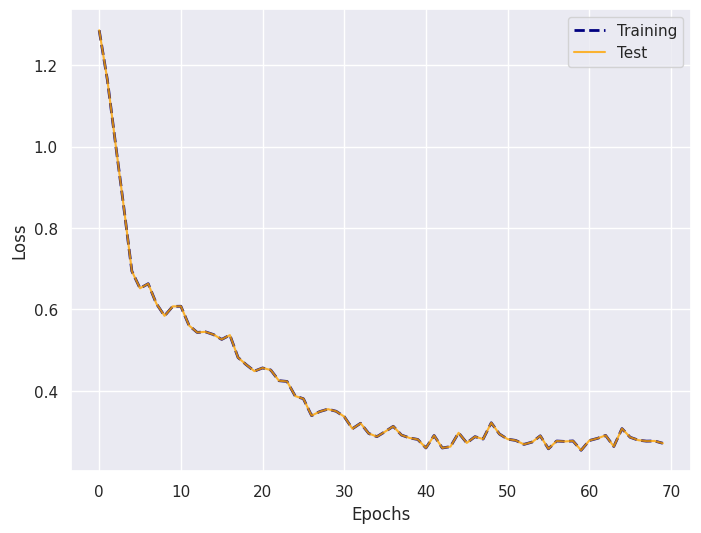

In [30]:
plt.figure()
plt.plot(range(num_epochs), train_loss_array, label='Training', linestyle='dashed', linewidth=2, color='navy')
plt.plot(range(num_epochs), train_loss_array, label='Test', alpha=0.8, color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [22]:
# Test the model
average_test_loss_accuracy(mlp_model, test_loader, loss_criterion)

Average test loss: 0.2726, Accuracy: 90.69%


Accuracy = 0.781
Precision = 0.853
Recall = 0.781
F1-score = 0.811
Area under PRC = 0.668


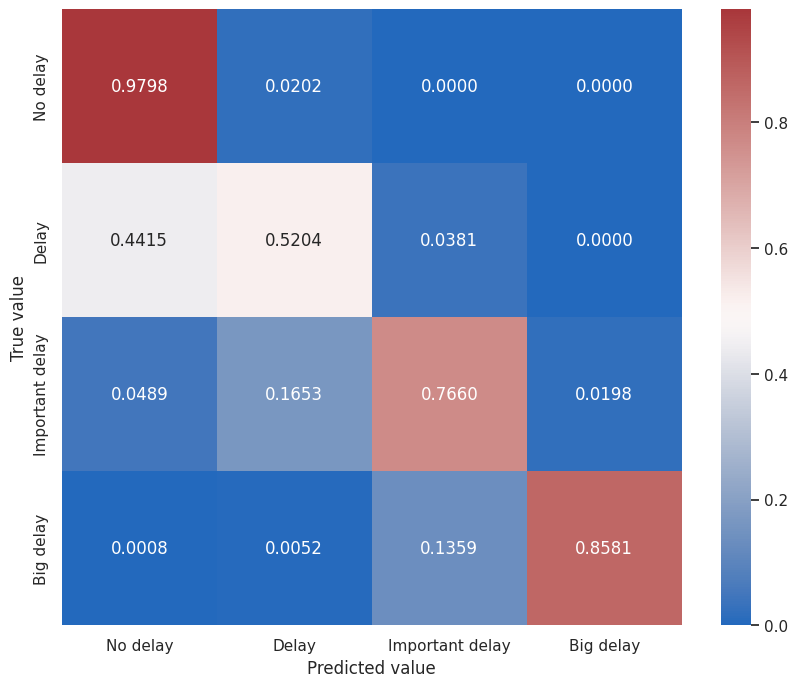

In [13]:
# Evaluate performance with various metrics
Y_pred = mlp_model(X_test)

print('Accuracy = {:.3f}'.format(multiclass_accuracy(Y_pred, Y_test, average='macro', num_classes=4)))
print('Precision = {:.3f}'.format(multiclass_precision(Y_pred, Y_test, average='macro', num_classes=4)))
print('Recall = {:.3f}'.format(multiclass_recall(Y_pred, Y_test, average='macro', num_classes=4)))
print('F1-score = {:.3f}'.format(multiclass_f1_score(Y_pred, Y_test, average='macro', num_classes=4)))
print('Area under PRC = {:.3f}'.format(multiclass_auprc(Y_pred, Y_test, average='macro', num_classes=4)))

conf_matrix = multiclass_confusion_matrix(Y_pred, Y_test, num_classes=4, normalize='true').cpu().numpy()
conf_matrix = pd.DataFrame(conf_matrix, index=['No delay', 'Delay', 'Important delay', 'Big delay'], columns=['No delay', 'Delay', 'Important delay', 'Big delay'])

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, cmap='vlag', fmt='.4f')
plt.ylabel('True value')
plt.xlabel('Predicted value')
plt.show()

## Model predictions interpretation with Captum

Captum is a model interpretability and understanding library for PyTorch models, developed by Facebook AI. We use this library to get attribution scores for our predictions to better understand the influence of input features on output.

In [14]:
X_test.shape

torch.Size([418700, 79])

In [15]:
# define a baseline to
baseline = torch.zeros(X_test.shape).to(device)

# feature attribution with Integrated gradients
ig = IntegratedGradients(mlp_model)

attributions, delta = ig.attribute(X_test, baseline, target=0, return_convergence_delta=True)
print('IG Attributions:', attributions)
print('Convergence Delta:', delta)

OutOfMemoryError: ignored